In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

from scipy import stats

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# 1. Load the data and understand the variables

### Load the dataset

In [2]:
housing = pd.read_csv('https://ml-course3-upgrad.s3.amazonaws.com/Assignment_+Advanced+Regression/train.csv')
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Inspect the columns

In [3]:
housing.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# 2. Data Inspection

### Find the percentage of missing values

In [4]:
null_counts = housing.isnull().sum() * 100 / len(housing)
null_counts[null_counts > 0]

LotFrontage     17.739726
Alley           93.767123
MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64

### Replace the 'NA' values according to the data dictionary

In [5]:
housing['LotFrontage'].fillna(0, inplace=True)
housing['Alley'].fillna('NoAlleyAccess', inplace=True)
housing['GarageType'].fillna('NoGarage', inplace=True)
housing['MasVnrType'].fillna('NoMasonry', inplace=True)
housing['MasVnrArea'].fillna(0, inplace=True)
housing['BsmtFinType1'].fillna('NoBasement', inplace=True)
housing['BsmtFinType2'].fillna('NoBasement', inplace=True)
housing['GarageType'].fillna('NoGarage', inplace=True)
housing['GarageFinish'].fillna('NoGarage', inplace=True)
housing['Fence'].fillna('NoFence', inplace=True)
housing['MiscFeature'].fillna('NoMiscFeature', inplace=True)

### Fill the garage built year with a the house's built year for houses that don't have garages

In [6]:
housing['GarageYrBlt'].fillna(housing['YearBuilt'].mean(), inplace=True)

### Fix what appears to be some typos in the dataset

In [7]:
housing['Exterior1st'] = housing['Exterior1st'].replace({'Wd Shng':'Wd Sdng'})
housing['Exterior2nd'] = housing['Exterior2nd'].replace({'Wd Shng':'Wd Sdng'})
housing['Exterior1st'] = housing['Exterior1st'].replace({'CmentBd':'CemntBd'})
housing['Exterior2nd'] = housing['Exterior2nd'].replace({'CmentBd':'CemntBd'})

### Drop categorical variables that have very few distictive values

In [8]:
undifferentiated_variables = ['Heating', 'PoolQC', 'RoofMatl', 'Utilities', 'Street']

for column in undifferentiated_variables:
    print('---' + column + '---')
    print(housing[column].value_counts())
    print('\n')

housing.drop(undifferentiated_variables, axis=1, inplace=True)

---Heating---
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64


---PoolQC---
Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64


---RoofMatl---
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64


---Utilities---
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


---Street---
Pave    1454
Grvl       6
Name: Street, dtype: int64




### Drop the meaningless id column 

In [9]:
housing.drop('Id', axis=1, inplace=True)

## Inspect and encode ordinal variables with numeric values

### Encode subjective ordinal variables that are rated Poor...Excelent

In [10]:
subjective_encoding = {'Ex':5,
                    'Gd':4,
                    'TA':3,
                    'Fa':2,
                    'Po':1,
                    'NA':0}
subjective_variables = ['ExterQual',
                     'ExterCond',
                     'GarageQual',
                     'GarageCond',
                     'BsmtQual',
                     'BsmtCond',
                     'HeatingQC',
                     'KitchenQual',
                     'FireplaceQu',
                     'GarageQual']

for variable in subjective_variables:
    housing[variable] = housing[variable].replace(subjective_encoding).fillna(value=0)

for column in subjective_variables:
    print('---' + column + '---')
    print(housing[column].describe())
    print(housing[column].value_counts())
    print('\n')

---ExterQual---
count    1460.00000
mean        3.39589
std         0.57428
min         2.00000
25%         3.00000
50%         3.00000
75%         4.00000
max         5.00000
Name: ExterQual, dtype: float64
3    906
4    488
5     52
2     14
Name: ExterQual, dtype: int64


---ExterCond---
count    1460.000000
mean        3.083562
std         0.351054
min         1.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: ExterCond, dtype: float64
3    1282
4     146
2      28
5       3
1       1
Name: ExterCond, dtype: int64


---GarageQual---
count    1460.000000
mean        2.810274
std         0.722898
min         0.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: GarageQual, dtype: float64
3.0    1311
0.0      81
2.0      48
4.0      14
5.0       3
1.0       3
Name: GarageQual, dtype: int64


---GarageCond---
count    1460.000000
mean        2.808904
std         0.719685
min         0.000000
25

### Encode subjective ordinal variables that are rated arbritrarily

In [11]:
housing['GarageFinish'] = housing['GarageFinish'].replace({'Fin':3, 'RFn':2, 'Unf':1, 'NA':0})

In [12]:
housing['BsmtExposure'].fillna(0, inplace=True)
housing['BsmtExposure'] = housing['BsmtExposure'].replace({'Gd':5, 'Av':4, 'Mn':2, 'No':1, 'NA':0})

In [13]:
housing['Functional'] = housing['Functional'].replace({'Typ':8, 'Min1':7, 'Min2':6, 'Mod':5, 'Maj1':4, 'Maj2':3, 'Sev':2, 'Sal':1})

### Inspect subective ordinal variables that already in numeric format

In [14]:
print('---OverallQual---')
print(housing['OverallQual'].value_counts())
print(housing['OverallQual'].describe())
print('\n')
print('---OverallCond---')
print(housing['OverallCond'].value_counts())
print(housing['OverallCond'].describe())

---OverallQual---
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64
count    1460.000000
mean        6.099315
std         1.382997
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64


---OverallCond---
5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64
count    1460.000000
mean        5.575342
std         1.112799
min         1.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: OverallCond, dtype: float64


### Inspect the Continuous Quatitative Variables

In [15]:
continuous_quantitative_variables = ['LotArea',
                  'BsmtFinSF1',
                  'BsmtFinSF2',
                  'BsmtUnfSF',
                  'TotalBsmtSF',
                  '1stFlrSF',
                  '2ndFlrSF',
                  'LowQualFinSF',
                  'GrLivArea',
                  'GarageArea',
                  'WoodDeckSF',
                  'OpenPorchSF',
                  'EnclosedPorch',
                  '3SsnPorch',
                  'ScreenPorch',
                  'PoolArea']

for column in continuous_quantitative_variables:
    print('---' + column + '---')
    print(housing[column].describe())
    print('\n')

---LotArea---
count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64


---BsmtFinSF1---
count    1460.000000
mean      443.639726
std       456.098091
min         0.000000
25%         0.000000
50%       383.500000
75%       712.250000
max      5644.000000
Name: BsmtFinSF1, dtype: float64


---BsmtFinSF2---
count    1460.000000
mean       46.549315
std       161.319273
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: BsmtFinSF2, dtype: float64


---BsmtUnfSF---
count    1460.000000
mean      567.240411
std       441.866955
min         0.000000
25%       223.000000
50%       477.500000
75%       808.000000
max      2336.000000
Name: BsmtUnfSF, dtype: float64


---TotalBsmtSF---
count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       

## Inspect and encode the categorical variables

### Combine variables that capture the same data fields

In [16]:
# Combine 'Condition1' and 'Condition2'
condition_1 = pd.get_dummies(housing['Condition1'], prefix='Condition', prefix_sep=' ')
condition_1.drop('Condition Norm', axis=1, inplace=True)
condition_2 = pd.get_dummies(housing['Condition2'], prefix='Condition', prefix_sep=' ')
condition_2.drop('Condition Norm', axis=1, inplace=True)

# Combine the values
condition_combined = condition_1.add(condition_2)

# Drop the categories with less than 10 values
condition_combined = condition_combined[condition_combined.columns[condition_combined.sum() >= 10]]

print(condition_combined.sum())

housing = pd.concat([housing, condition_combined], axis=1)
housing.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

Condition Artery    50
Condition Feedr     87
Condition PosN      21
Condition RRAe      12
Condition RRAn      27
dtype: int64


In [17]:
# Combine 'Exterior1st' and 'Exterior2nd'
exterior_1st = pd.get_dummies(housing['Exterior1st'], prefix='Exterior', prefix_sep=' ')
exterior_2nd = pd.get_dummies(housing['Exterior2nd'], prefix='Exterior', prefix_sep=' ')

# Combine the values
exterior_combined = exterior_1st.add(exterior_2nd, fill_value=0)

# Drop the categories with less than 10 values
exterior_combined = exterior_combined[exterior_combined.columns[exterior_combined.sum() >= 10]]
exterior_combined.sum()

print(exterior_combined.sum())

housing = pd.concat([housing, exterior_combined], axis=1)
housing.drop(['Exterior1st', 'Exterior2nd'], axis=1, inplace=True)

Exterior AsbShng      40.0
Exterior BrkFace      75.0
Exterior CemntBd     121.0
Exterior HdBoard     429.0
Exterior ImStucc      11.0
Exterior MetalSd     434.0
Exterior Plywood     250.0
Exterior Stucco       51.0
Exterior VinylSd    1019.0
Exterior Wd Sdng     441.0
Exterior WdShing      26.0
dtype: float64


### Encode binary indicators to numeric values

In [18]:
housing['CentralAir'] = housing['CentralAir'].replace({'N':0, 'Y':1})

### Create dummy variables with one-hot encoding

In [19]:
dummy_source_variables = ['MSSubClass',
                          'MSZoning',
                          'Alley',
                          'LotShape',
                          'LandContour',
                          'LotConfig',
                          'LandSlope',
                          'Neighborhood',
                          'BldgType',
                          'HouseStyle',
                          'RoofStyle',
                          'MasVnrType',
                          'Foundation',
                          'BsmtFinType1',
                          'BsmtFinType2',
                          'GarageType',
                          'GarageFinish',
                          'PavedDrive',
                          'Fence',
                          'MiscFeature',
                          'SaleType',
                          'SaleCondition']

for variable in dummy_source_variables:
    dummy_variables = pd.get_dummies(housing[variable], prefix=variable, prefix_sep=' ')
    
    # Drop the dummy variable column with the smallest number of values
    dummy_variables.drop(dummy_variables.mean().idxmin(), axis=1)
    
    # Drop any dummy variable columns with less than 20 values
    dummy_variables = dummy_variables[dummy_variables.columns[dummy_variables.sum() >= 20]]
    
    # Inspect the results
    print('---' + variable + '---')
    print(dummy_variables)
    #print(dummy_variables.value_counts().sum())
    
    # Add the dummy variables to the main dataframe
    housing = pd.concat([housing, dummy_variables], axis=1)
    
# Drop the existing variables from the main dataframe
housing.drop(dummy_source_variables, axis=1, inplace=True)

---MSSubClass---
      MSSubClass 20  MSSubClass 30  MSSubClass 50  MSSubClass 60  \
0                 0              0              0              1   
1                 1              0              0              0   
2                 0              0              0              1   
3                 0              0              0              0   
4                 0              0              0              1   
...             ...            ...            ...            ...   
1455              0              0              0              1   
1456              1              0              0              0   
1457              0              0              0              0   
1458              1              0              0              0   
1459              1              0              0              0   

      MSSubClass 70  MSSubClass 80  MSSubClass 85  MSSubClass 90  \
0                 0              0              0              0   
1                 0           

---BldgType---
      BldgType 1Fam  BldgType 2fmCon  BldgType Duplex  BldgType Twnhs  \
0                 1                0                0               0   
1                 1                0                0               0   
2                 1                0                0               0   
3                 1                0                0               0   
4                 1                0                0               0   
...             ...              ...              ...             ...   
1455              1                0                0               0   
1456              1                0                0               0   
1457              1                0                0               0   
1458              1                0                0               0   
1459              1                0                0               0   

      BldgType TwnhsE  
0                   0  
1                   0  
2                   0  
3           

---SaleCondition---
      SaleCondition Abnorml  SaleCondition Family  SaleCondition Normal  \
0                         0                     0                     1   
1                         0                     0                     1   
2                         0                     0                     1   
3                         1                     0                     0   
4                         0                     0                     1   
...                     ...                   ...                   ...   
1455                      0                     0                     1   
1456                      0                     0                     1   
1457                      0                     0                     1   
1458                      0                     0                     1   
1459                      0                     0                     1   

      SaleCondition Partial  
0                         0  
1                  

## Remove the outliers

### Remove records that have outliers in the target variable

In [20]:
housing['SalePrice'].describe([0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995])

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
0.5%      55000.000000
1%        61815.970000
5%        88000.000000
10%      106475.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
90%      278000.000000
95%      326100.000000
99%      442567.010000
99.5%    527331.915000
max      755000.000000
Name: SalePrice, dtype: float64

In [21]:
housing = housing[housing['SalePrice'] < 527331.915]
housing = housing[housing['SalePrice'] >= 55000.000]
len(housing)

1445

## Create derived variables

### Create a derived variable from the 'Electrical' variable
Indicate that the house uses circuit breaker instead of fuses.

In [22]:
print(housing['Electrical'].value_counts())
housing['Electrical'].fillna('SBrkr', inplace=True)
housing['Electrical SBrkr'] = housing['Electrical'].replace({'SBrkr':1, 'FuseA':0, 'FuseF':0, 'FuseP': 0, 'Mix':0})
print(housing['Electrical SBrkr'].value_counts())

housing.drop('Electrical', axis=1, inplace=True)

SBrkr    1323
FuseA      91
FuseF      26
FuseP       3
Mix         1
Name: Electrical, dtype: int64
1    1324
0     121
Name: Electrical SBrkr, dtype: int64


### Create derived variables to capture elapsed time

In [23]:
housing['YearsSinceBuilt'] = housing['YearBuilt'].max() - housing['YearBuilt']
housing.drop('YearBuilt', axis=1, inplace=True)

housing['YearsSinceRemodAdd'] = housing['YearRemodAdd'].max() - housing['YearRemodAdd']
housing.drop('YearRemodAdd', axis=1, inplace=True)

housing['YearsSinceSold'] = housing['YrSold'].max() - housing['YrSold']
housing.drop('YearsSinceSold', axis=1, inplace=True)

## Review the modified dataset

In [24]:
housing.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1445 entries, 0 to 1459
Data columns (total 169 columns):
 #    Column                     Dtype  
---   ------                     -----  
 0    LotFrontage                float64
 1    LotArea                    int64  
 2    OverallQual                int64  
 3    OverallCond                int64  
 4    MasVnrArea                 float64
 5    ExterQual                  int64  
 6    ExterCond                  int64  
 7    BsmtQual                   float64
 8    BsmtCond                   float64
 9    BsmtExposure               int64  
 10   BsmtFinSF1                 int64  
 11   BsmtFinSF2                 int64  
 12   BsmtUnfSF                  int64  
 13   TotalBsmtSF                int64  
 14   HeatingQC                  int64  
 15   CentralAir                 int64  
 16   1stFlrSF                   int64  
 17   2ndFlrSF                   int64  
 18   LowQualFinSF               int64  
 19   GrLivArea                

### Verify that there are no more missing values

In [25]:
housing.columns[housing.isna().any()].tolist()

[]

# 3. EDA

### Compute the correlation between numerical variables

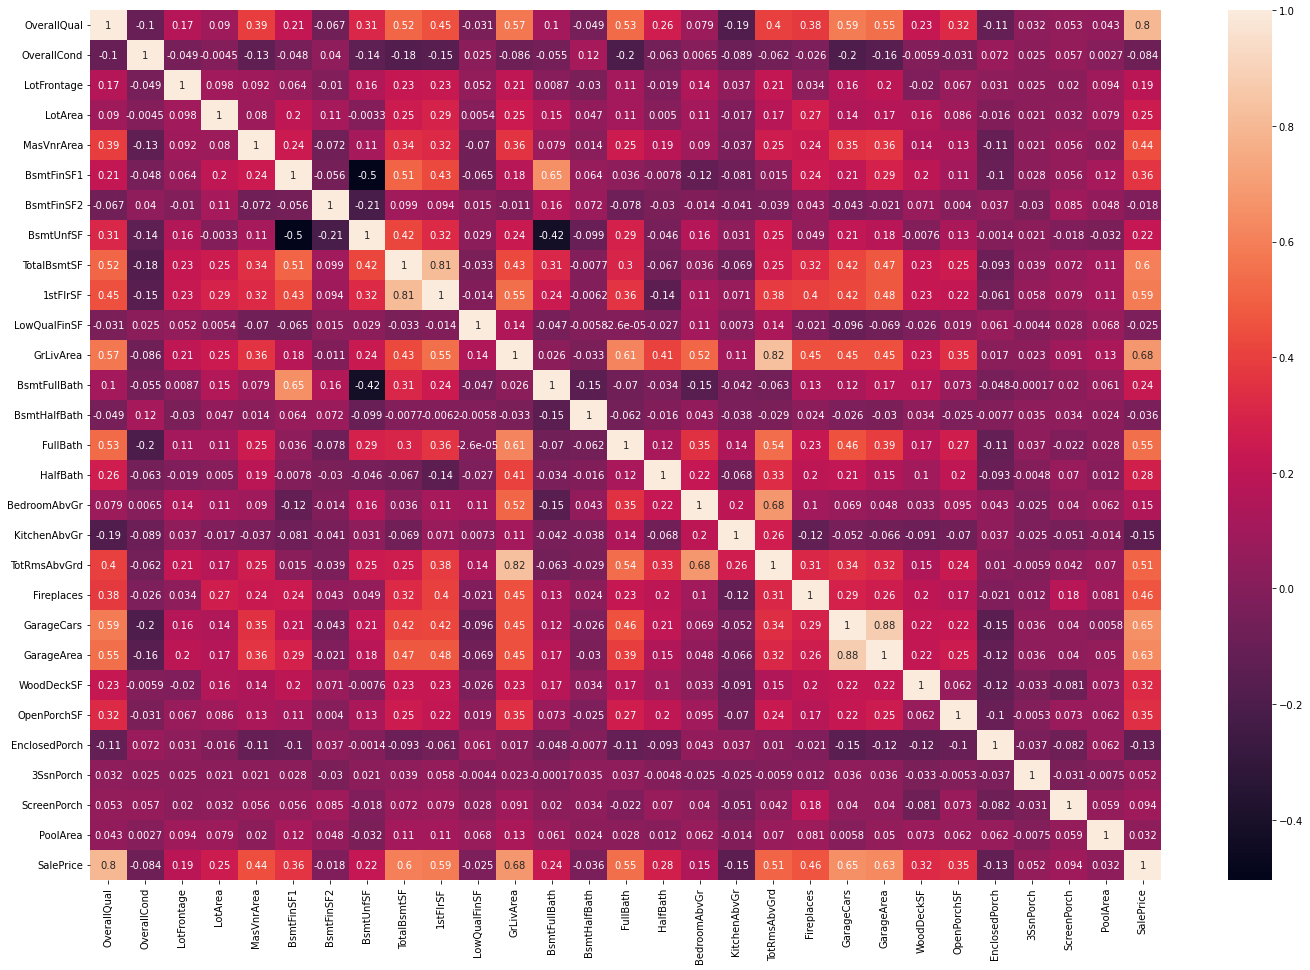

In [26]:
housing_corr = housing[['OverallQual',
                        'OverallCond',
                        'LotFrontage',
                        'LotArea',
                        'MasVnrArea',
                        'BsmtFinSF1',
                        'BsmtFinSF2',
                        'BsmtUnfSF',
                        'TotalBsmtSF',
                        '1stFlrSF',
                        'LowQualFinSF',
                        'GrLivArea',
                        'BsmtFullBath',
                        'BsmtHalfBath',
                        'FullBath',
                        'HalfBath',
                        'BedroomAbvGr',
                        'KitchenAbvGr',
                        'TotRmsAbvGrd',
                        'Fireplaces',
                        'GarageCars',
                        'GarageArea',
                        'WoodDeckSF',
                        'OpenPorchSF',
                        'EnclosedPorch',
                        '3SsnPorch',
                        'ScreenPorch',
                        'PoolArea',
                        'SalePrice']].corr();
plt.figure(figsize=(24,16))
sns.heatmap(housing_corr ,annot=True)
plt.show()

### Compute the correlation between numerical variables and the target variable

In [27]:
print(housing.corrwith(housing['SalePrice']).sort_values(ascending=False).to_string())

SalePrice                    1.000000
OverallQual                  0.799446
ExterQual                    0.692455
GrLivArea                    0.682564
KitchenQual                  0.663260
GarageCars                   0.648738
GarageArea                   0.631430
TotalBsmtSF                  0.595630
BsmtQual                     0.593621
1stFlrSF                     0.587555
FullBath                     0.547151
FireplaceQu                  0.533618
Foundation PConc             0.509278
TotRmsAbvGrd                 0.507227
GarageYrBlt                  0.502431
Fireplaces                   0.464644
BsmtFinType1 GLQ             0.442291
MasVnrArea                   0.441806
HeatingQC                    0.434753
GarageFinish 3               0.413311
Neighborhood NridgHt         0.408167
MSSubClass 60                0.369913
SaleType New                 0.366746
SaleCondition Partial        0.361084
BsmtFinSF1                   0.359894
GarageType Attchd            0.358492
OpenPorchSF 

### Plot the relationship between numerical predictor variables and the target variable

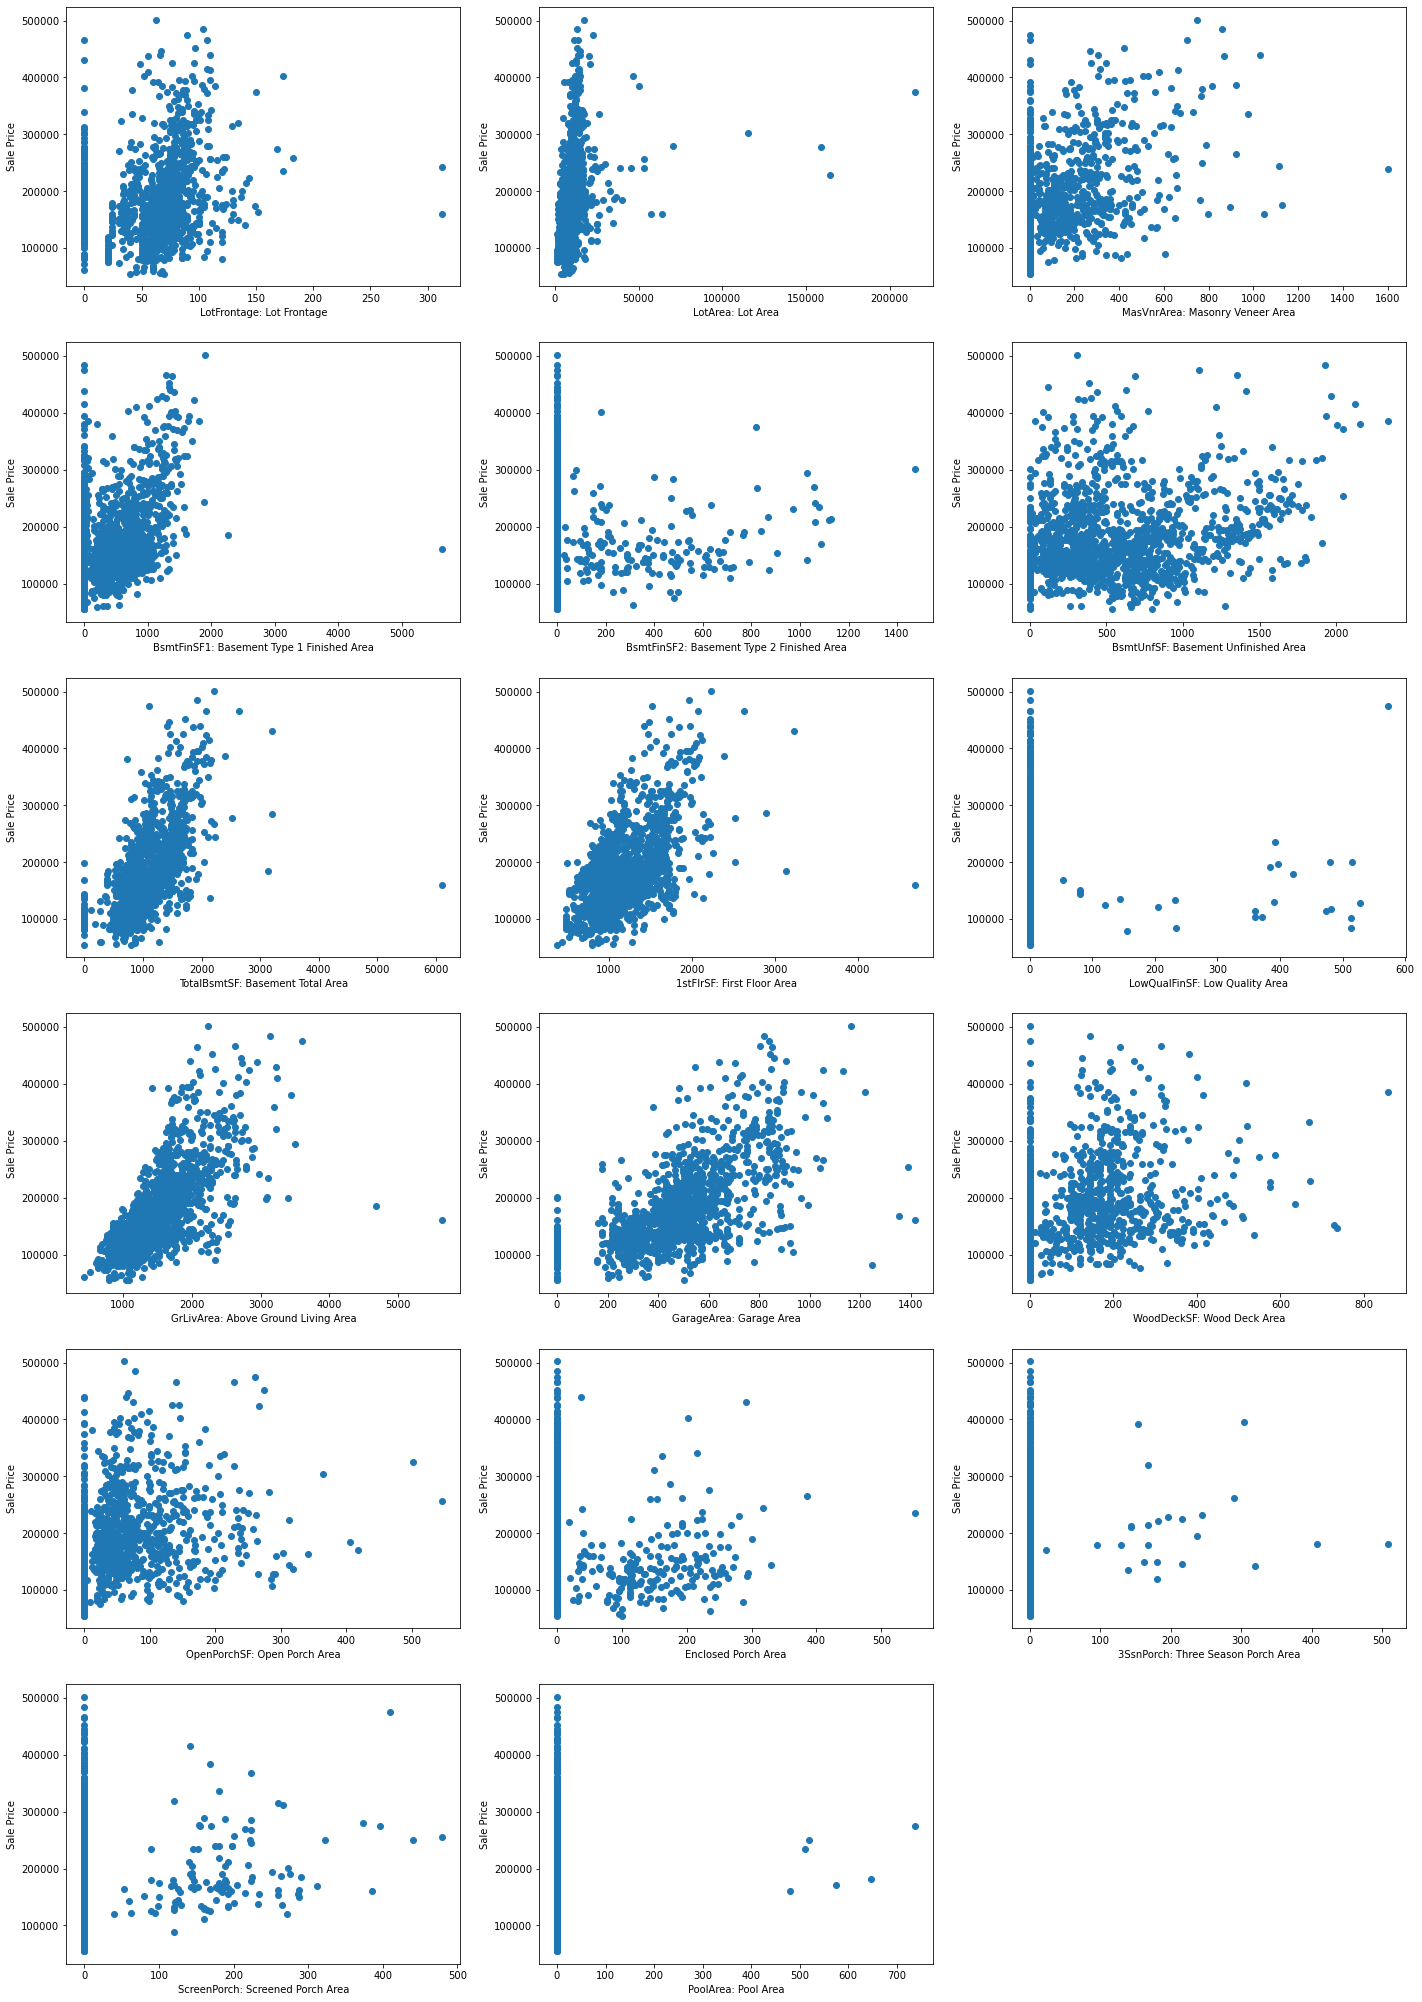

In [28]:
plt.figure(figsize=(24,36))

plt.subplot(6,3,1)
plt.scatter(housing['LotFrontage'], housing['SalePrice'])
plt.xlabel('LotFrontage: Lot Frontage')
plt.ylabel('Sale Price')

plt.subplot(6,3,2)
plt.scatter(housing['LotArea'], housing['SalePrice'])
plt.xlabel('LotArea: Lot Area')
plt.ylabel('Sale Price')

plt.subplot(6,3,3)
plt.scatter(housing['MasVnrArea'], housing['SalePrice'])
plt.xlabel('MasVnrArea: Masonry Veneer Area')
plt.ylabel('Sale Price')

plt.subplot(6,3,4)
plt.scatter(housing['BsmtFinSF1'], housing['SalePrice'])
plt.xlabel('BsmtFinSF1: Basement Type 1 Finished Area')
plt.ylabel('Sale Price')

plt.subplot(6,3,5)
plt.scatter(housing['BsmtFinSF2'], housing['SalePrice'])
plt.xlabel('BsmtFinSF2: Basement Type 2 Finished Area')
plt.ylabel('Sale Price')

plt.subplot(6,3,6)
plt.scatter(housing['BsmtUnfSF'], housing['SalePrice'])
plt.xlabel('BsmtUnfSF: Basement Unfinished Area')
plt.ylabel('Sale Price')

plt.subplot(6,3,7)
plt.scatter(housing['TotalBsmtSF'], housing['SalePrice'])
plt.xlabel('TotalBsmtSF: Basement Total Area')
plt.ylabel('Sale Price')

plt.subplot(6,3,8)
plt.scatter(housing['1stFlrSF'], housing['SalePrice'])
plt.xlabel('1stFlrSF: First Floor Area')
plt.ylabel('Sale Price')

plt.subplot(6,3,9)
plt.scatter(housing['LowQualFinSF'], housing['SalePrice'])
plt.xlabel('LowQualFinSF: Low Quality Area')
plt.ylabel('Sale Price')

plt.subplot(6,3,10)
plt.scatter(housing['GrLivArea'], housing['SalePrice'])
plt.xlabel('GrLivArea: Above Ground Living Area')
plt.ylabel('Sale Price')

plt.subplot(6,3,11)
plt.scatter(housing['GarageArea'], housing['SalePrice'])
plt.xlabel('GarageArea: Garage Area')
plt.ylabel('Sale Price')

plt.subplot(6,3,12)
plt.scatter(housing['WoodDeckSF'], housing['SalePrice'])
plt.xlabel('WoodDeckSF: Wood Deck Area')
plt.ylabel('Sale Price')

plt.subplot(6,3,13)
plt.scatter(housing['OpenPorchSF'], housing['SalePrice'])
plt.xlabel('OpenPorchSF: Open Porch Area')
plt.ylabel('Sale Price')

plt.subplot(6,3,14)
plt.scatter(housing['EnclosedPorch'], housing['SalePrice'])
plt.xlabel('Enclosed Porch Area')
plt.ylabel('Sale Price')

plt.subplot(6,3,15)
plt.scatter(housing['3SsnPorch'], housing['SalePrice'])
plt.xlabel('3SsnPorch: Three Season Porch Area')
plt.ylabel('Sale Price')

plt.subplot(6,3,16)
plt.scatter(housing['ScreenPorch'], housing['SalePrice'])
plt.xlabel('ScreenPorch: Screened Porch Area')
plt.ylabel('Sale Price')

plt.subplot(6,3,17)
plt.scatter(housing['PoolArea'], housing['SalePrice'])
plt.xlabel('PoolArea: Pool Area')
plt.ylabel('Sale Price')

plt.show()

### Plot the relationship between the derived elapsed time variables and the target variable

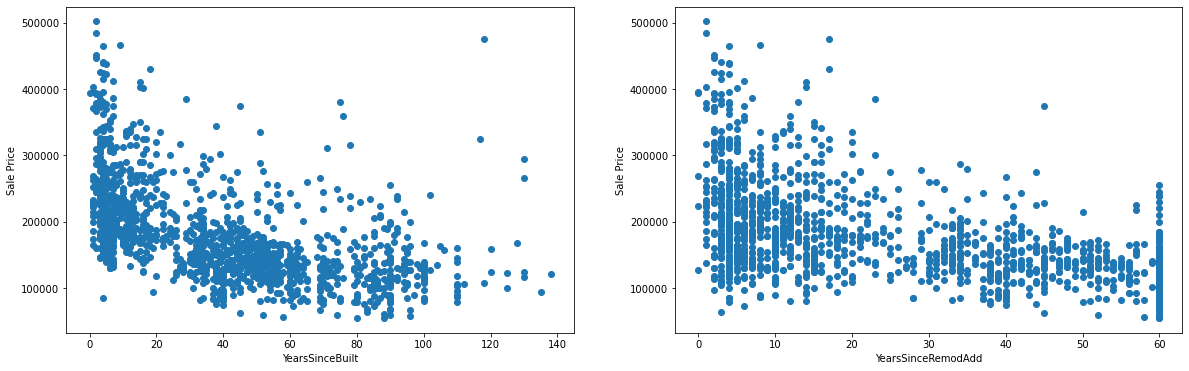

In [29]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.scatter(housing['YearsSinceBuilt'], housing['SalePrice'])
plt.xlabel('YearsSinceBuilt')
plt.ylabel('Sale Price')

plt.subplot(1,2,2)
plt.scatter(housing['YearsSinceRemodAdd'], housing['SalePrice'])
plt.xlabel('YearsSinceRemodAdd')
plt.ylabel('Sale Price')

plt.show()

### Use boxplots to show how the discrete categorical variables relate to the predicted variable

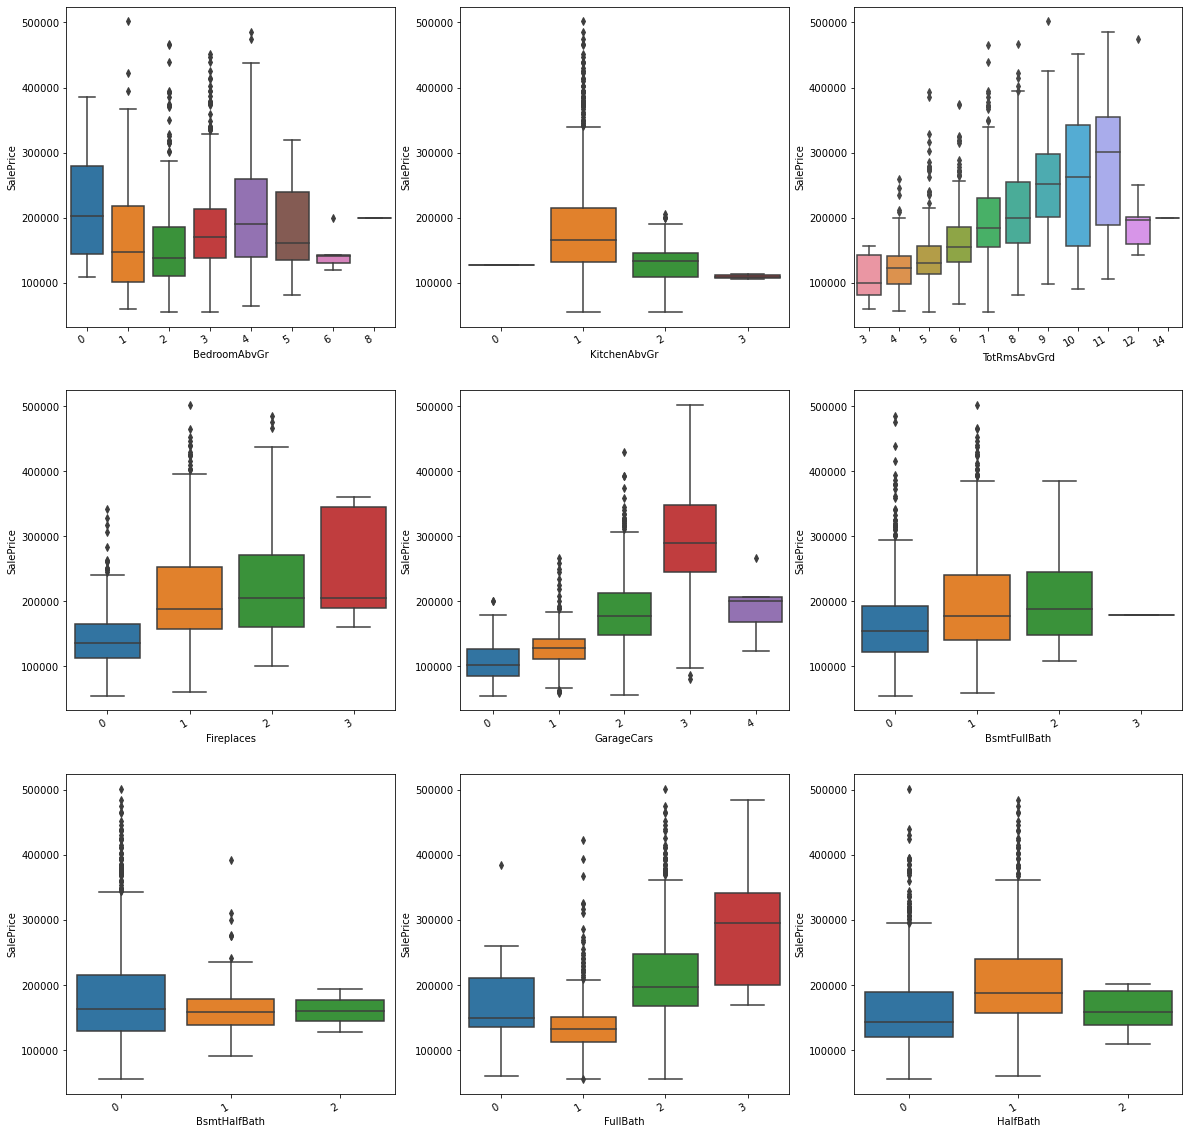

In [30]:
plt.figure(figsize = (20,20))

plt.subplot(3,3,1)
sns.boxplot(data=housing, x='BedroomAbvGr', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.subplot(3,3,2)
sns.boxplot(data=housing, x='KitchenAbvGr', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.subplot(3,3,3)
sns.boxplot(data=housing, x='TotRmsAbvGrd', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.subplot(3,3,4)
sns.boxplot(data=housing, x='Fireplaces', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.subplot(3,3,5)
sns.boxplot(data=housing, x='GarageCars', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.subplot(3,3,6)
sns.boxplot(data=housing, x='BsmtFullBath', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.subplot(3,3,7)
sns.boxplot(data=housing, x='BsmtHalfBath', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.subplot(3,3,8)
sns.boxplot(data=housing, x='FullBath', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.subplot(3,3,9)
sns.boxplot(data=housing, x='HalfBath', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.show()

### Use boxplots to show how the subjective ratings relate to the predicted variable

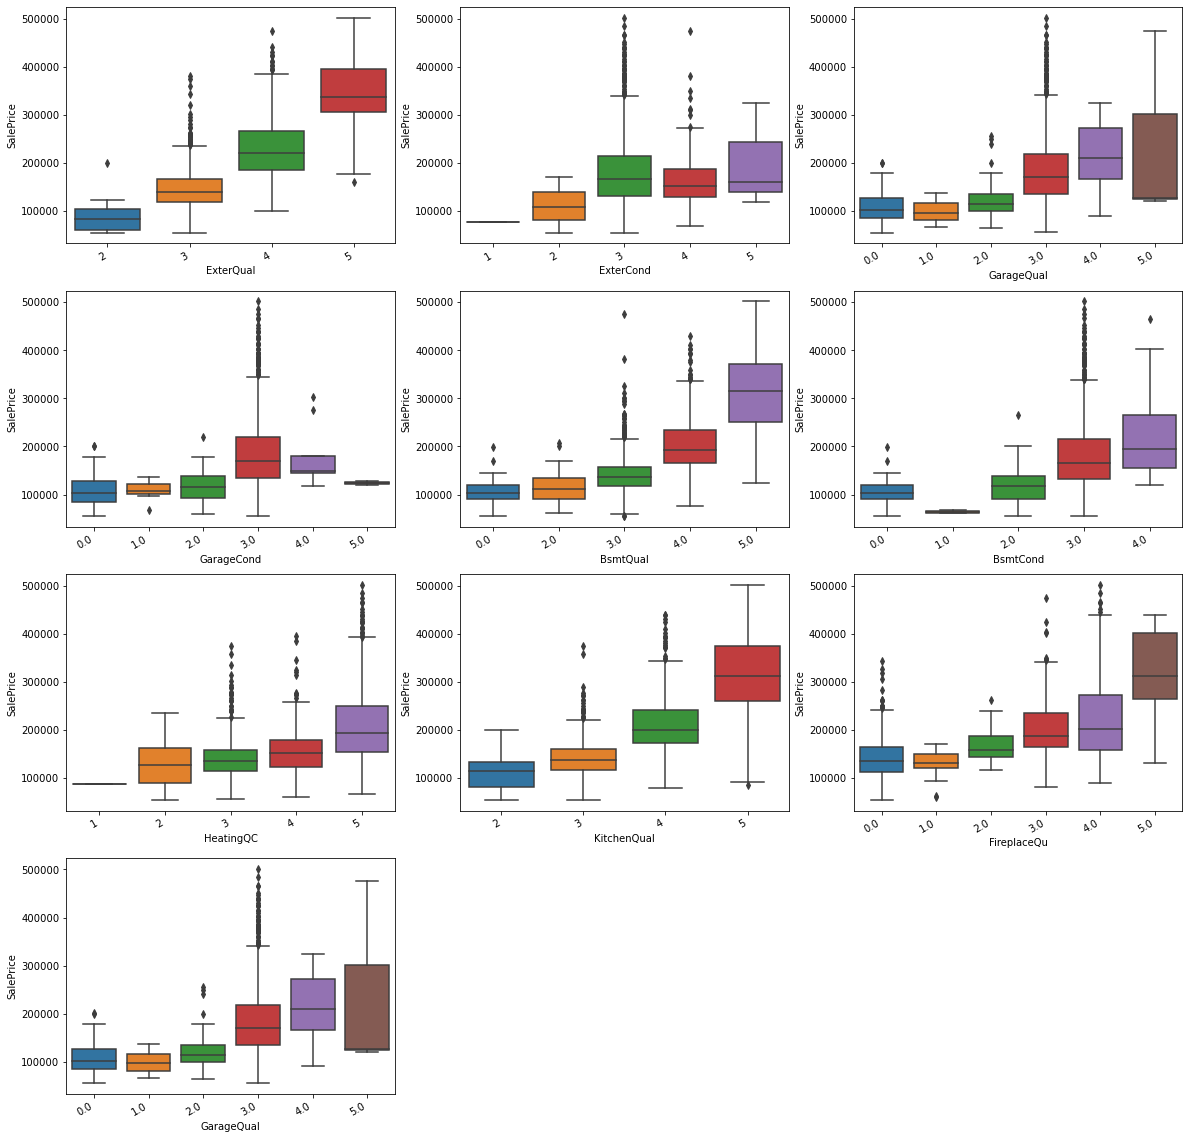

In [31]:
plt.figure(figsize = (20,20))

plt.subplot(4,3,1)
sns.boxplot(data=housing, x='ExterQual', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.subplot(4,3,2)
sns.boxplot(data=housing, x='ExterCond', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.subplot(4,3,3)
sns.boxplot(data=housing, x='GarageQual', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.subplot(4,3,4)
sns.boxplot(data=housing, x='GarageCond', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.subplot(4,3,5)
sns.boxplot(data=housing, x='BsmtQual', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.subplot(4,3,6)
sns.boxplot(data=housing, x='BsmtCond', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.subplot(4,3,7)
sns.boxplot(data=housing, x='HeatingQC', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.subplot(4,3,8)
sns.boxplot(data=housing, x='KitchenQual', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.subplot(4,3,9)
sns.boxplot(data=housing, x='FireplaceQu', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.subplot(4,3,10)
sns.boxplot(data=housing, x='GarageQual', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.show()

### Use boxplots to show how the subjective overall house ratings relate to the predicted variable

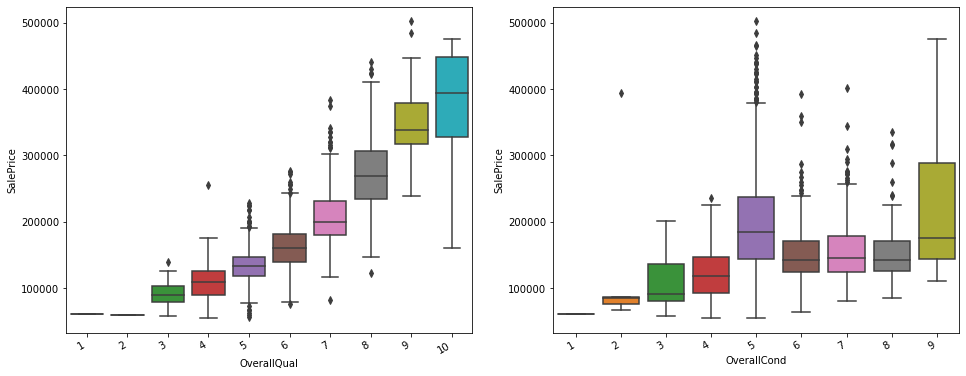

In [32]:
plt.figure(figsize = (16,6))

plt.subplot(1,2,1)
sns.boxplot(data=housing, x='OverallQual', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.subplot(1,2,2)
sns.boxplot(data=housing, x='OverallCond', y='SalePrice')
plt.xticks(rotation=30, ha='right')

plt.show()

### Plot the distribution of the target variable

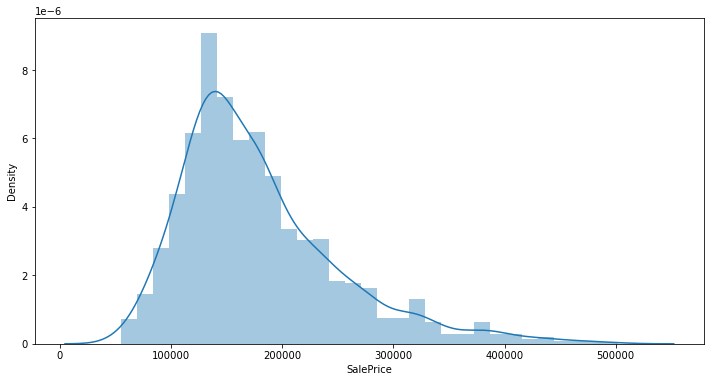

In [33]:
plt.figure(figsize=(12,6))
sns.distplot(housing.SalePrice)
plt.show()

# 4. Train-Test Split 

### Randomly split the dataset into training and test

In [34]:
housing_train, housing_test = train_test_split(housing, train_size=0.75, random_state=28342)
print(housing_train.shape)
print(housing_test.shape)

(1083, 169)
(362, 169)


# 5. Scaling

### Scale the numerical variables

In [35]:
# Find the variables that require scaling
scaled_variables = []
for column in housing:
    if housing[column].max() > 1.0:
        scaled_variables.append(column)

print(scaled_variables)

# Scale the variables
scaler = MinMaxScaler()
housing_train[scaled_variables] = scaler.fit_transform(housing_train[scaled_variables])
housing_test[scaled_variables] = scaler.transform(housing_test[scaled_variables])
housing_train.describe()

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'Condition Artery', 'Condition Feedr', 'Condition PosN', 'Exterior AsbShng', 'Exterior BrkFace', 'Exterior CemntBd', 'Exterior HdBoard', 'Exterior ImStucc', 'Exterior MetalSd', 'Exterior Plywood', 'Exterior Stucco', 'Exterior VinylSd', 'Exterior Wd Sdng', 'YearsSinceBuilt', 'YearsSinceRemodAdd']


,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,...,SaleType COD,SaleType New,SaleType WD,SaleCondition Abnorml,SaleCondition Family,SaleCondition Normal,SaleCondition Partial,Electrical SBrkr,YearsSinceBuilt,YearsSinceRemodAdd
count,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000,...,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000,1083.000000
mean,0.181321,0.043360,0.563148,0.570175,0.062446,0.461373,0.523315,0.697507,0.737073,0.366944,...,0.023084,0.076639,0.879963,0.064635,0.014774,0.831948,0.078486,0.921514,0.279865,0.425239
std,0.108701,0.051289,0.147352,0.136839,0.109198,0.185810,0.087181,0.170742,0.133189,0.289011,...,0.150240,0.266141,0.325155,0.245995,0.120702,0.374085,0.269059,0.269059,0.216076,0.344420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.127796,0.029061,0.444444,0.500000,0.000000,0.333333,0.500000,0.600000,0.750000,0.200000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.072464,0.108333
50%,0.201278,0.038094,0.555556,0.500000,0.000000,0.333333,0.500000,0.800000,0.750000,0.200000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.275362,0.283333
75%,0.250799,0.047765,0.666667,0.625000,0.099375,0.666667,0.500000,0.800000,0.750000,0.400000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.405797,0.733333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Split the predictor and target variables

In [36]:
y_train = housing_train.pop('SalePrice')
X_train = housing_train

y_test = housing_test.pop('SalePrice')
X_test = housing_test

# 6. Modelling & Tuning with Regularization

## Lasso Models

### Create Lasso models with different levels of regularization

In [37]:
alpha_values = [0.0000001,
                0.0000002,
                0.0000004,
                0.0000006,
                0.0000008,
                0.000001,
                0.000002,
                0.000004,
                0.000006,
                0.000008,
                0.00001,
                0.00002,
                0.00004,
                0.00006,
                0.00008,
                0.0001,
                0.0002,
                0.0004,
                0.0006,
                0.0008,
                0.001,
                0.002,
                0.004,
                0.006,
                0.008,
                0.01,
                0.02,
                0.04,
                0.06,
                0.08,
                0.1,
                0.2,
                0.4,
                0.6,
                0.8,
                1,
                2,
                4,
                6,
                8,
                10,
                20,
                40,
                60,
                80,
                100]

lasso_result_list = []
for alpha_hyperparameter in alpha_values:
    lm = Lasso(alpha = alpha_hyperparameter)
    lm.fit(X_train, y_train)
    
    y_train_pred = lm.predict(X_train)
    train_r2 = r2_score(y_true=y_train, y_pred=y_train_pred)

    y_test_pred = lm.predict(X_test)
    test_r2 = r2_score(y_true=y_test, y_pred=y_test_pred)
    
    selected_parameters = []
    for parameter in list(lm.coef_):
        if abs(parameter) > 0:
            selected_parameters.append(parameter)
    
    adjusted_r2 = 1 - ( (1 - train_r2) * (len(X_train) - 1) / (len(X_train) - len(selected_parameters) - 1) )
    
    lasso_result_list.append([alpha_hyperparameter, train_r2, test_r2, adjusted_r2, len(selected_parameters)])

lasso_results = pd.DataFrame(lasso_result_list, columns = ['Alpha', 'Train R2 Score', 'Test R2 Score', 'Train Adjusted R2', 'Number of Parameters'])
lasso_results

,Alpha,Train R2 Score,Test R2 Score,Train Adjusted R2,Number of Parameters
0,1.000000e-07,0.904029,0.826331,0.887130,162
1,2.000000e-07,0.904029,0.826383,0.887252,161
2,4.000000e-07,0.904029,0.826487,0.887006,163
3,6.000000e-07,0.904028,0.826590,0.887128,162
4,8.000000e-07,0.904027,0.826693,0.887250,161
5,1.000000e-06,0.904026,0.826796,0.887249,161
6,2.000000e-06,0.904017,0.827306,0.887116,162
7,4.000000e-06,0.903982,0.828301,0.887074,162
8,6.000000e-06,0.903928,0.829173,0.887256,160
9,8.000000e-06,0.903849,0.830064,0.887164,160


### Plot the effect of the alpha hyperparameter on the R-squared scores of the Lasso Models

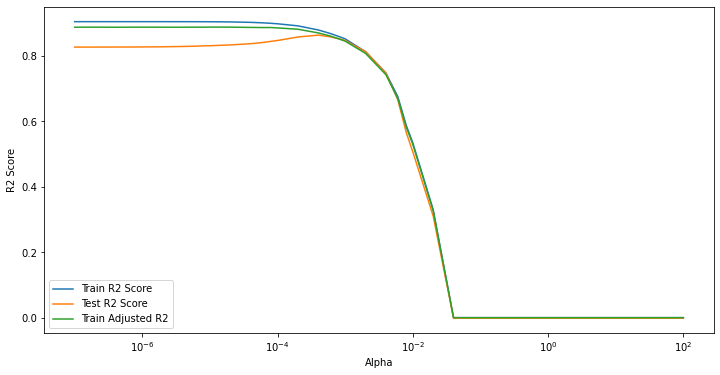

In [38]:
ax = plt.figure(figsize=(12,6))
plt.plot(lasso_results['Alpha'], lasso_results['Train R2 Score'])
plt.plot(lasso_results['Alpha'], lasso_results['Test R2 Score'])
plt.plot(lasso_results['Alpha'], lasso_results['Train Adjusted R2'])
plt.legend(['Train R2 Score', 'Test R2 Score', 'Train Adjusted R2'], loc='lower left')
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.xscale('log')
plt.show()

### Plot the effect of the number of selected variables on the Adjusted R-squared score

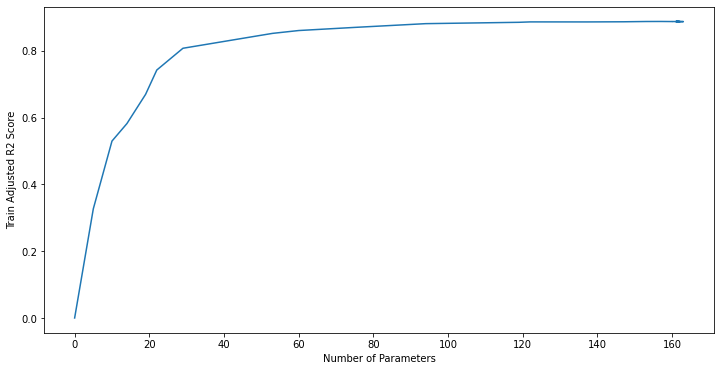

In [39]:
ax = plt.figure(figsize=(12, 6))
plt.plot(lasso_results['Number of Parameters'], lasso_results['Train Adjusted R2'])
plt.ylabel('Train Adjusted R2 Score')
plt.xlabel('Number of Parameters')
plt.show()

## Ridge Models

### Create Ridge models with different levels of regularization

In [40]:
alpha_values = [0.0001,
                0.0002,
                0.0004,
                0.0006,
                0.0008,
                0.001,
                0.002,
                0.004,
                0.006,
                0.008,
                0.01,
                0.02,
                0.04,
                0.06,
                0.08,
                0.1,
                0.2,
                0.4,
                0.6,
                0.8,
                1,
                2,
                4,
                6,
                8,
                10,
                20,
                40,
                60,
                80,
                100,
                200,
                400,
                600,
                800,
                1000,
                2000,
                4000,
                6000,
                8000,
                10000,
                20000,
                40000,
                60000,
                80000,
                100000]
    
ridge_result_list = []
for alpha_hyperparameter in alpha_values:

    ridge = Ridge(alpha = alpha_hyperparameter)
    ridge.fit(X_train, y_train)

    y_train_pred = ridge.predict(X_train)
    train_r2 = r2_score(y_true=y_train, y_pred=y_train_pred)
    
    y_test_pred = ridge.predict(X_test)
    test_r2 = r2_score(y_true=y_test, y_pred=y_test_pred)
    
    ridge_result_list.append([alpha_hyperparameter, train_r2, test_r2])

ridge_results = pd.DataFrame(ridge_result_list, columns = ['Alpha', 'Train R2 Score', 'Test R2 Score'])
ridge_results

,Alpha,Train R2 Score,Test R2 Score
0,0.0001,0.904029,0.826280
1,0.0002,0.904029,0.826285
2,0.0004,0.904029,0.826294
3,0.0006,0.904029,0.826304
4,0.0008,0.904029,0.826313
5,0.0010,0.904029,0.826323
6,0.0020,0.904029,0.826370
7,0.0040,0.904029,0.826464
8,0.0060,0.904029,0.826558
9,0.0080,0.904028,0.826651


### Plot the effect of the alpha hyperparameter on the R-squared scores of the Ridge models

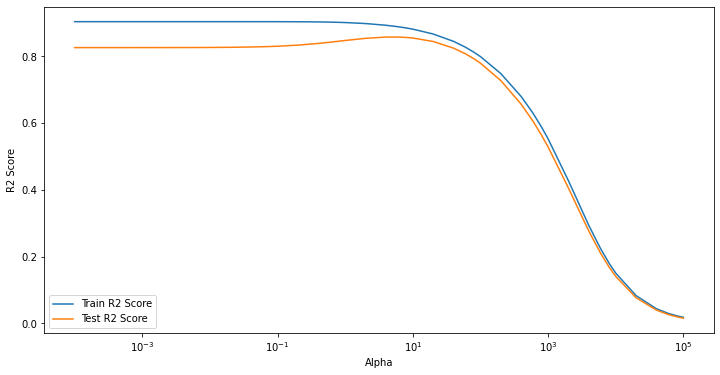

In [41]:
ax = plt.figure(figsize=(12,6))
plt.plot(ridge_results['Alpha'], ridge_results['Train R2 Score'])
plt.plot(ridge_results['Alpha'], ridge_results['Test R2 Score'])
plt.legend(['Train R2 Score', 'Test R2 Score'], loc='lower left')
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.xscale('log')
plt.show()

## Final Model

### Lasso with alpha = 0.0004 and 75 parameters

In [42]:
# Choosing 0.0004 as the optimal alpha hyperparameter value for Lasso
lm = Lasso(alpha = 0.0004)
lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)
train_r2 = r2_score(y_true=y_train, y_pred=y_train_pred)
print('Training R2 Score:    ', train_r2)

y_test_pred = lm.predict(X_test)
test_r2 = r2_score(y_true=y_test, y_pred=y_test_pred)
print('Test R2 Score:        ', test_r2)
    
selected_parameters = []
for parameter in list(lm.coef_):
    if abs(parameter) > 0:
        selected_parameters.append(parameter)

adjusted_r2 = 1 - ( (1 - train_r2) * (len(X_train) - 1) / (len(X_train) - len(selected_parameters) - 1) )
print('Training Adjusted R2: ', adjusted_r2)

print('Number of Parameters: ', len(selected_parameters))

# List the most influential parameters
model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
colums = housing_train.columns
colums.insert(0, 'const')
coeficients = pd.DataFrame(list(zip(colums,model_parameters)), columns = ['Parameter','Coeficient'])
coeficients.sort_values(by='Coeficient', key=abs, ascending=False).head(20)


Training R2 Score:     0.8787066274947364
Test R2 Score:         0.8629595628193546
Training Adjusted R2:  0.8696728609228448
Number of Parameters:  75


,Parameter,Coeficient
20,BsmtFullBath,0.357785
3,OverallCond,0.233686
0,LotFrontage,-0.155433
33,GarageArea,0.086154
103,Neighborhood OldTown,0.080115
109,Neighborhood Timber,0.066244
102,Neighborhood NridgHt,0.057923
52,Exterior CemntBd,0.050917
6,ExterCond,0.049402
27,TotRmsAbvGrd,0.041497


# 7. Model Evaluation

## Residual Analysis

### Plot the Residuals

In [43]:
# Compute the training data residuals
train_residuals = y_train - y_train_pred
print('---Training Residuals---')
print(train_residuals.describe())

# Compute the test data residuals
print('---Test Residuals---')
test_residuals = y_test - y_test_pred
print(test_residuals.describe())

---Training Residuals---
count    1.083000e+03
mean    -4.900153e-17
std      5.496598e-02
min     -6.126807e-01
25%     -2.829310e-02
50%     -8.975821e-04
75%      2.382031e-02
max      3.010250e-01
Name: SalePrice, dtype: float64
---Test Residuals---
count    362.000000
mean       0.002106
std        0.062898
min       -0.581030
25%       -0.027059
50%        0.000183
75%        0.028665
max        0.367466
Name: SalePrice, dtype: float64


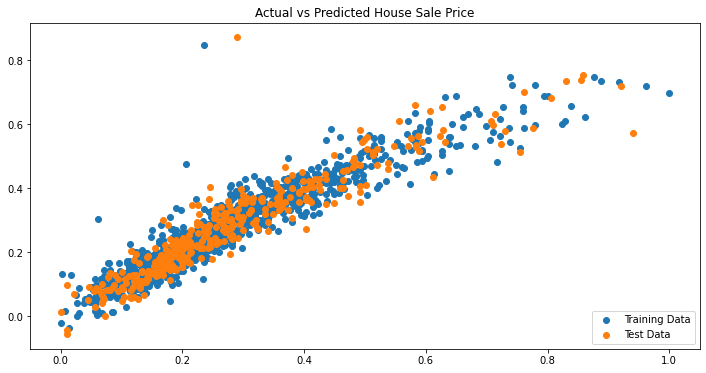

In [44]:
# Plot the actual test data against the predicted test data
fig = plt.figure(figsize=(12,6))
plt.scatter(y_train, y_train_pred)
plt.scatter(y_test, y_test_pred)
plt.legend(labels=['Training Data','Test Data'], loc='lower right')
plt.title('Actual vs Predicted House Sale Price')
plt.show()

### Plot the Residual Distribution

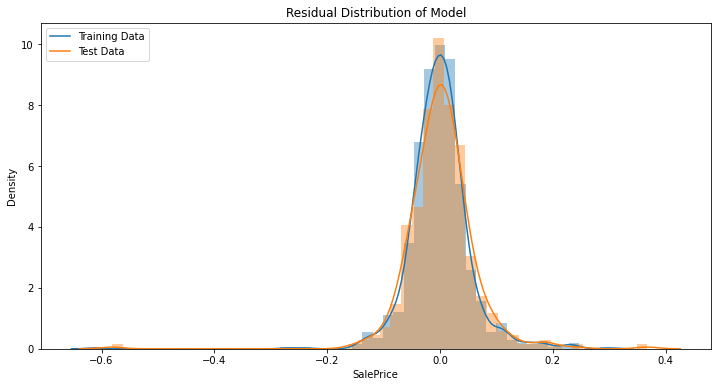

In [45]:
# Plot the training and test data residual distributions
fig = plt.figure(figsize=(12,6))
sns.distplot(train_residuals)
sns.distplot(test_residuals)
plt.title('Residual Distribution of Model')
plt.legend(labels=['Training Data','Test Data'], loc='upper left')
plt.show()